# Altitude: An Observational Study ⛰️

Hypothesis: Long range field goals have a greater change of conversion at altitude than sea-level.

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import mysql.connector
import itertools
import dtale
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from util.data import clean, get_data

## Load & Clean

In [2]:
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
df = get_data(cnx, 'g.seas<=2019', xp=False, base='raw_6_cat')
df = clean(df, dropna=False)
df

,fkicker,good,dist,year,seasons,temperature,home_team,stadium,team,XP,...,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,,,,,
2166,AD-0800,1,38,2000,17,73,BUF,Ralph Wilson Stadium,TEN,0,...,1,10,1,0,0,1,0,1,0.764708,765
2185,AD-0800,1,27,2000,17,73,BUF,Ralph Wilson Stadium,TEN,0,...,1,10,1,0,0,1,0,1,0.807721,766
4565,AD-0800,1,36,2000,17,80,TEN,Adelphia Coliseum,TEN,0,...,1,13,0,0,1,0,0,5,NaN,767
8564,AD-0800,1,24,2000,17,61,PIT,Three Rivers Stadium,TEN,0,...,0,16,1,0,0,1,1,1,0.842837,768
8628,AD-0800,1,40,2000,17,61,PIT,Three Rivers Stadium,TEN,0,...,0,16,1,0,0,1,1,1,0.871516,769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862982,ZG-0050,1,30,2019,3,66,ARI,State Farm Stadium,ARI,0,...,0,0,0,0,0,0,0,1,0.826709,62
865338,ZG-0050,1,21,2019,3,66,ARI,State Farm Stadium,ARI,0,...,0,11,0,0,0,0,0,2,0.858217,63
868268,ZG-0050,1,22,2019,3,43,SEA,CenturyLink Field,ARI,0,...,1,7,1,0,0,1,0,1,1.000000,64


## Explore

There seems to be a slight up-tick for long range kicks (+45 yards), but the sample size is quite small, as indicated by the confidence bands.

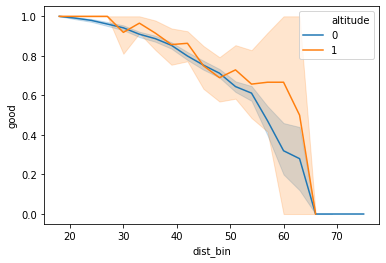

In [3]:
df_ = df.copy()
df_['dist_bin'] = 3*round(df_['dist']/3)
sns.lineplot(x='dist_bin', y='good', hue='altitude', data=df_)

## Pair

We filter for away kicks at altitude and greater than 45 yards.

In [4]:
df_altitude = df[(df['altitude']==1) & (df['away_game']==1) & (df['dist']>=45)]
df_altitude = df_altitude.fillna({'form':'bfill'})
df_altitude

,fkicker,good,dist,year,seasons,temperature,home_team,stadium,team,XP,...,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,,,,,
573508,AH-2600,0,46,2013,3,76,DEN,Sports Authority Field at Mile High,PHI,0,...,0,8,1,0,0,0,0,0,0.759397,67
756432,AR-1450,1,51,2017,2,61,DEN,Sports Authority Field at Mile High,NYG,0,...,0,4,1,0,0,0,0,1,0.635956,6
149261,AV-0400,1,46,2003,8,35,DEN,Invesco Field at Mile High,NE\r,0,...,0,0,1,0,1,0,0,1,0.868980,343
227963,AV-0400,0,53,2005,10,75,DEN,Invesco Field at Mile High,NE\r,0,...,0,5,1,0,1,0,0,1,0.928239,415
276456,AV-0400,1,48,2006,11,70,DEN,Invesco Field at Mile High,IND,0,...,0,4,1,0,0,0,0,2,0.806131,445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423132,SJ-0300,1,54,2009,10,57,DEN,Invesco Field at Mile High,OAK,0,...,0,6,1,0,0,0,0,1,0.698193,340
477009,SJ-0300,1,63,2011,12,75,DEN,Sports Authority Field at Mile High,OAK,0,...,0,6,1,0,1,0,0,1,0.962146,390
787697,SJ-0300,0,46,2018,19,84,DEN,Sports Authority Field at Mile High,SEA,0,...,0,5,1,0,0,0,0,1,0.837361,568


We find paired kicks at sea-level in the original dataset.

In [5]:
def get_mask(data, row, ddist=3, dwind=6, dtemp=10, dyear=2, dpres=2, dkicks=150, dseas=2, dage=3):
    mask = (data['altitude']!=row['altitude']) &\
           (abs(data['kicks']-row['kicks'])<=dkicks) &\
           (abs(data['seasons']-row['seasons'])<=dseas) &\
           (abs(data['age']-row['age'])<=dage) &\
           (abs(data['dist']-row['dist'])<=ddist) &\
           (abs(data['wind']-row['wind'])<=dwind) &\
           (abs(data['temperature']-row['temperature'])<=dtemp) &\
           (abs(data['year']-row['year'])<=dyear) &\
           (data['postseason']==row['postseason']) &\
           (data['turf']==row['turf']) &\
           (data['iced']==row['iced']) &\
           (data['away_game']==row['away_game']) &\
           (data['precipitation']==row['precipitation']) &\
           (abs(data['pressure']-row['pressure'])<=dpres)
    return mask

def get_diff(df, row):
    for i in row.index:
        if not isinstance(row[i],str):
            df[i+'_d'] = df[i].sub(row[i]).abs()
    return df

In [6]:
sealevel = {}
for index, row in df_altitude.iterrows():
    mask = get_mask(df, row)
    df_choices = get_diff(df[mask],row).sort_values(['dist_d','year_d','kicks_d','wind_d','temperature_d','seasons_d','age_d'])
    for i, choice in df_choices.iterrows():
        if i not in sealevel:
            choice['match_pid'] = index
            sealevel[i] = choice
            break
print(len(df_altitude)-len(sealevel), 'are missing matches.')
df_sealevel = pd.DataFrame.from_dict(sealevel, orient='index').sort_values(['dist_d','year_d','seasons_d'])
df_sealevel

32 are missing matches.


,fkicker,good,dist,year,seasons,temperature,home_team,stadium,team,XP,...,wind_d,away_game_d,postseason_d,iced_d,turf_d,precipitation_d,pressure_d,form_d,kicks_d,match_pid
652786,CS-0250,1,48,2015,2,70,HOU,NRG Stadium,KC\r,0,...,5,0,0,0,0,0,1,0.051611,23,676741
279219,AV-0400,0,46,2006,11,31,NE,Gillette Stadium,IND,0,...,4,0,0,0,0,0,1,0.071778,65,299646
432650,MC-3000,1,56,2010,4,69,PHI,Lincoln Financial Field,GB\r,0,...,0,0,0,0,0,0,0,0.136032,17,444935
504391,NF-0300,1,45,2011,5,53,WAS,FedEx Field,NYJ,0,...,2,0,0,0,0,0,1,0.150538,1,498700
516305,NN-0200,1,51,2011,7,56,OAK,O.co Coliseum Oakland,SD\r,0,...,2,0,0,0,0,0,1,0.148743,23,486829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634760,SS-3100,1,49,2014,10,25,TEN,LP Field,PIT,0,...,3,0,0,0,0,0,1,0.143870,13,692673
419921,RL-0900,0,51,2009,10,42,KC,Arrowhead Stadium,BUF,0,...,3,0,0,0,0,0,1,0.101920,15,469346
402301,MC-3000,0,55,2009,3,50,CLE,Cleveland Browns Stadium,GB\r,0,...,6,0,0,0,0,0,0,0.061033,42,453530
136150,JF-0900,0,55,2003,3,75,CAR,Ericsson Stadium,ATL,0,...,5,0,0,0,0,0,0,0.175323,87,173992


We are missing several matches, but I'm not willing to relax any of the parameters any further.

In [7]:
missing = df_altitude.drop(index=df_sealevel['match_pid'])
missing

,fkicker,good,dist,year,seasons,temperature,home_team,stadium,team,XP,...,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,,,,,
149261,AV-0400,1,46,2003,8,35,DEN,Invesco Field at Mile High,NE\r,0,...,0,0,1,0,1,0,0,1,0.868980,343
227963,AV-0400,0,53,2005,10,75,DEN,Invesco Field at Mile High,NE\r,0,...,0,5,1,0,1,0,0,1,0.928239,415
701922,AV-0400,1,48,2016,21,85,DEN,Sports Authority Field at Mile High,IND,0,...,0,4,1,0,0,0,0,1,0.677337,739
701977,AV-0400,1,52,2016,21,85,DEN,Sports Authority Field at Mile High,IND,0,...,0,4,1,0,0,0,0,1,0.736003,740
697366,GG-0100,0,50,2016,8,85,DEN,Sports Authority Field at Mile High,CAR,0,...,0,10,1,0,1,0,0,6,0.760521,189
289389,JB-7100,0,53,2006,4,16,DEN,Invesco Field at Mile High,SEA,0,...,1,0,1,0,0,0,0,1,0.546113,110
289476,JB-7100,1,50,2006,4,16,DEN,Invesco Field at Mile High,SEA,0,...,1,0,1,0,0,0,0,5,0.629689,113
258271,JR-1100,1,47,2005,4,34,DEN,Invesco Field at Mile High,PIT,0,...,0,11,1,1,0,0,0,1,0.639553,121
318065,JR-1100,0,65,2007,6,37,DEN,Invesco Field at Mile High,PIT,0,...,0,10,1,0,1,0,0,1,0.758709,157


We now filter our altitude dataframe and we have both our datasets ready.

In [8]:
df_altitude = df_altitude.loc[df_sealevel['match_pid'],:]
df_altitude

,fkicker,good,dist,year,seasons,temperature,home_team,stadium,team,XP,...,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,,,,,
676741,CS-0250,0,48,2015,2,64,DEN,Sports Authority Field at Mile High,KC\r,0,...,0,5,1,0,1,0,0,0,0.878216,54
299646,JN-0600,1,46,2006,11,32,DEN,Invesco Field at Mile High,SF\r,0,...,0,4,1,0,0,0,0,1,0.844996,385
444935,NF-0300,1,56,2010,4,73,DEN,Invesco Field at Mile High,NYJ,0,...,0,4,1,0,0,0,0,1,0.985850,94
498700,NF-0300,1,45,2011,5,54,DEN,Sports Authority Field at Mile High,NYJ,0,...,0,3,1,0,0,0,0,2,0.548621,139
486829,NN-0200,1,51,2011,7,52,DEN,Sports Authority Field at Mile High,SD\r,0,...,0,6,1,0,0,0,0,2,0.837263,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692673,MN-0800,1,52,2015,11,16,DEN,Sports Authority Field at Mile High,CIN,0,...,1,6,1,0,0,0,0,2,0.652972,262
469346,NR-0100,1,54,2010,11,50,DEN,Invesco Field at Mile High,HOU,0,...,0,7,1,0,0,0,0,1,0.811741,339
453530,RS-3400,0,52,2010,2,43,DEN,Invesco Field at Mile High,KC\r,0,...,0,6,1,0,0,0,0,1,0.900342,43


## Model

We work within a Bayesian framework, setting a prior distribution on the true population proportion and update the prior after our observations. The Beta-Binomial conjugacy makes this process relatively pain-free. Our prior mean is the sample population proportion (all kicks).

In [9]:
from scipy.stats import beta
p_hat = df[df['dist']>=45]['good'].mean()
# beta_ = 2
# alpha_ = int(round(p_hat*beta_/(1-p_hat)))
alpha_ = 12
beta_ = int(round(alpha_*(1-p_hat)/p_hat))
print(f'alpha: {alpha_}, beta: {beta_}')

alpha: 12, beta: 6


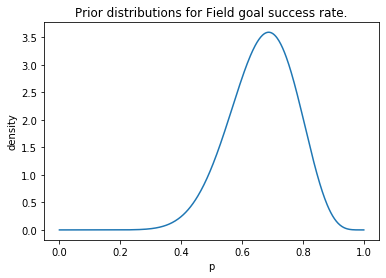

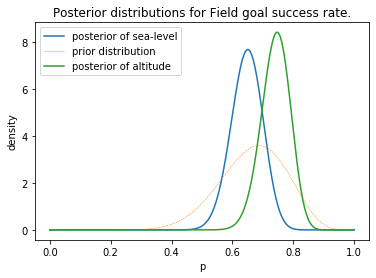

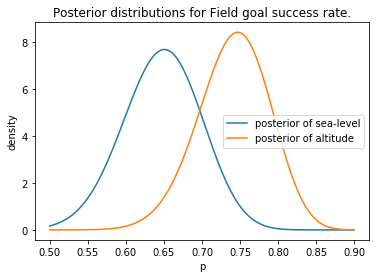

In [13]:
from util.bayes import BetaBinomial

control = BetaBinomial(alpha_, beta_, 'sea-level')
treatment = BetaBinomial(alpha_, beta_, 'altitude')
control.plot_prior(show=True)
plt.cla()

control.observe(df_sealevel['good'])
treatment.observe(df_altitude['good'])

control.plot_posterior(prior=False)
treatment.plot_posterior(show=True, prior=True)

# zoom in
x = np.linspace(0.5,0.9,500)
control.plot_posterior(x, prior=False, show=False)
treatment.plot_posterior(x, prior=False, show=True)

samples = 20000
samples_posterior_sea = control.sample(samples)
samples_posterior_alt = treatment.sample(samples)

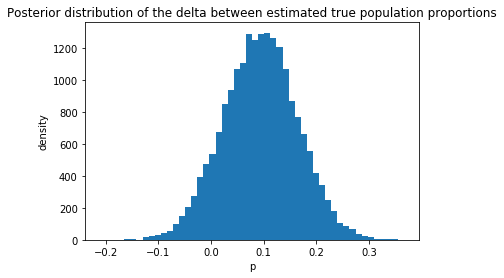

90% likely that altitude has a greater true population proportion of converted field goals.
0.09 is the median difference, with 50% credible interval of (0.0,0.19).


In [14]:
posterior_diff = samples_posterior_alt - samples_posterior_sea

plt.hist(posterior_diff, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of the delta between estimated true population proportions')
plt.show()
gt = int((samples_posterior_alt>samples_posterior_sea).mean()*100)
print(f'{gt}% likely that altitude has a greater true population proportion of converted field goals.')

from scipy.stats import bayes_mvs
alpha = 0.5
center, _, _ = bayes_mvs(posterior_diff, alpha=alpha)
print(f'{round(center.statistic,2)} is the median difference, with {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')

We are sometimes interested in relative increase. For instance, the difference between 0.6 and 0.7 is relatively larger than the difference between 0.7 and 0.8.
We calculate relative increase of our treatment (altitude) over control (sea-level) using our posterior distributions.

65 % likely relative lift is greater than 10%.
0.15 is the median relative lift, with 50% credible interval of (0.0,0.31).


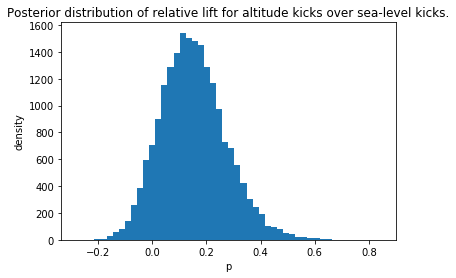

In [15]:
posterior_relative = (samples_posterior_alt-samples_posterior_sea)/samples_posterior_sea
plt.hist(posterior_relative, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of relative lift for altitude kicks over sea-level kicks.')
print(int((posterior_relative>0.1).mean()*100), r'% likely relative lift is greater than 10%.')

alpha = 0.5
center, _, _ = bayes_mvs(posterior_relative, alpha=alpha)
print(f'{round(center.statistic,2)} is the median relative lift, with {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')

## Conclusions

* Given our model, we are 91% sure that kicking at altitude is an advantage.
* The 50% credible interval for the difference in true population proportion is 0 to 0.19.
* Relatively speaking, on average, altitude provides a 15% increase in conversion probability over sea-level kicks.
* The 50% credible interval for relative lift between true proportions is 0% to +31%.